In [1]:
import pandas as pd

In [2]:
DATA = 'ech_dataset'

In [3]:
articles = !ls echr_dataset

In [4]:
!ls echr_dataset/Article6/

cases_a6.csv		     ngrams_a6_full.csv       ngrams_a6_relevantLaw.csv
ngrams_a6_circumstances.csv  ngrams_a6_law.csv	      topics6.csv
ngrams_a6_featureNames.txt   ngrams_a6_procedure.csv  topics6_vocab.txt


In [5]:
def get_article(path, features):
    files_raw = !ls {path}
    files_features = ['cases', 'circumstances', 'featureNames', 'full', 'law', 'procedure', 'relevantLaw', 'topics', 'topicsVocab']
    files = dict(zip(files_features, files_raw))
    
    group = []
    for feature in features:
        if(feature == 'topics'): raw = pd.read_csv(path+files[feature], sep='\t', header=None)
        elif(feature == 'topicsVocab'): raw = open(path+files[feature]).read(); raw.replace('\n', '').replace(', ', ',').split(',')
        else: raw = pd.read_csv(path+files[feature], header=None)
        
        if feature == 'cases': raw = raw[1]
            
        group.append(raw)
    return pd.concat(group, axis=1, ignore_index=True)

In [6]:
!ls echr_dataset

Article3  Article6  Article8


In [7]:
data = get_article('echr_dataset/Article8/', ['cases', 'full', 'circumstances'])

In [8]:
X = data.iloc[:, 1:]

In [9]:
y = data[0]

In [10]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000
0,0.004009,0.0,0.0,0.000000,0.001145,0.0,0.0,0.0,0.000573,0.004582,...,0.000000,0.0,0.00000,0.0,0.002358,0.002358,0.0,0.002358,0.0,0.0
1,0.000156,0.0,0.0,0.000156,0.000781,0.0,0.0,0.0,0.000000,0.001093,...,0.019655,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.000354,0.000000,0.0,0.0,0.0,0.001772,0.000709,...,0.000570,0.0,0.00057,0.0,0.000000,0.001141,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.005333,...,0.000000,0.0,0.00000,0.0,0.000000,0.004264,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

import numpy as np

In [ ]:
param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

In [ ]:
clf = make_pipeline(preprocessing.StandardScaler(), 
                    GridSearchCV(SVC(),
                                 param_grid=param_grid, cv=10, refit=True))

In [ ]:
feature_tests = [
    ['cases', 'full'],
    ['cases', 'procedure'],
    ['cases', 'circumstances'],
    ['cases', 'relevantLaw'],
    ['cases', 'circumstances', 'relevantLaw'],
    ['cases', 'law'],
    ['cases', 'topics'],
    ['cases', 'topics', 'circumstances']
]

In [ ]:
articles = !ls echr_dataset

for article in articles:
    article_mean = []
    for feature_test in feature_tests:
        data = get_article(f'echr_dataset/{article}/', feature_test)
        X = data.iloc[:, 1:]
        y = data[0]
        score = np.mean(cross_val_score(clf, X, y, cv=10))
        article_mean.append(score)
        print(f'{article} - {feature_test}: {score}')
    print(f'{article} - mean: {np.mean(article_mean)}')

In [12]:
X = X.as_matrix()

/home/nti14147326/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [13]:
X.reshape([254, 4000])
X.shape

(254, 4000)

In [14]:
y = np.array([[1] if i == 'v' else [0]  for i in y])
#y = y.reshape(254, 2)
y.shape

(254, 1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
X_train.shape

(177, 4000)

In [17]:
X_test.shape

(77, 4000)

In [18]:
y_train[:5]

array([[0],
       [1],
       [1],
       [0],
       [1]])

In [19]:
y_train.shape

(177, 1)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4000, 1000)
        self.bn1 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.fc4 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        x = F.dropout(x, training=self.training)
        x = nn.Sigmoid()(x)
        
        return x

In [22]:
net = Net()
opt = optim.Adam(net.parameters(), lr=0.0003, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [23]:
def  train(model, opt, criterion, batch_size=177):
    model.train()
    losses = []
    
    X_train2 = torch.from_numpy(X_train).float()
    y_train2 = torch.from_numpy(y_train).float()
    
    opt.zero_grad()
    y_predict = net(X_train2)
    loss = criterion(y_predict, y_train2)
    loss.backward()
    opt.step()        
        
    return loss

In [24]:
import matplotlib.pyplot as plt

Epoch 0: Loss: 0.730268657207489
Epoch 100: Loss: 0.35982823371887207
Epoch 200: Loss: 0.36947932839393616
Epoch 300: Loss: 0.36888372898101807
Epoch 400: Loss: 0.3647402822971344


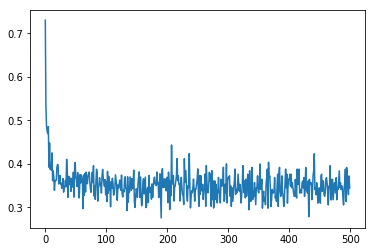

In [25]:
e_losses = []
num_epochs = 500
for e in range(num_epochs):
    loss = train(net, opt, criterion)
    e_losses.append(loss)
    if e % 100 == 0: 
        for param_group in opt.param_groups:
            param_group['lr'] /= 1.1
        print(f'Epoch {e}: Loss: {loss}')
        
plt.plot(e_losses)

In [26]:
out_pred = net(Variable(torch.from_numpy(X_test.reshape(-1, 4000)).float()))

In [27]:
t = Variable(torch.Tensor([0.5]))
y_pred = (out_pred > t).float() * 1

In [30]:
sum(y_pred.data.numpy() == y_test)/len(y_test)

array([0.61038961])